# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

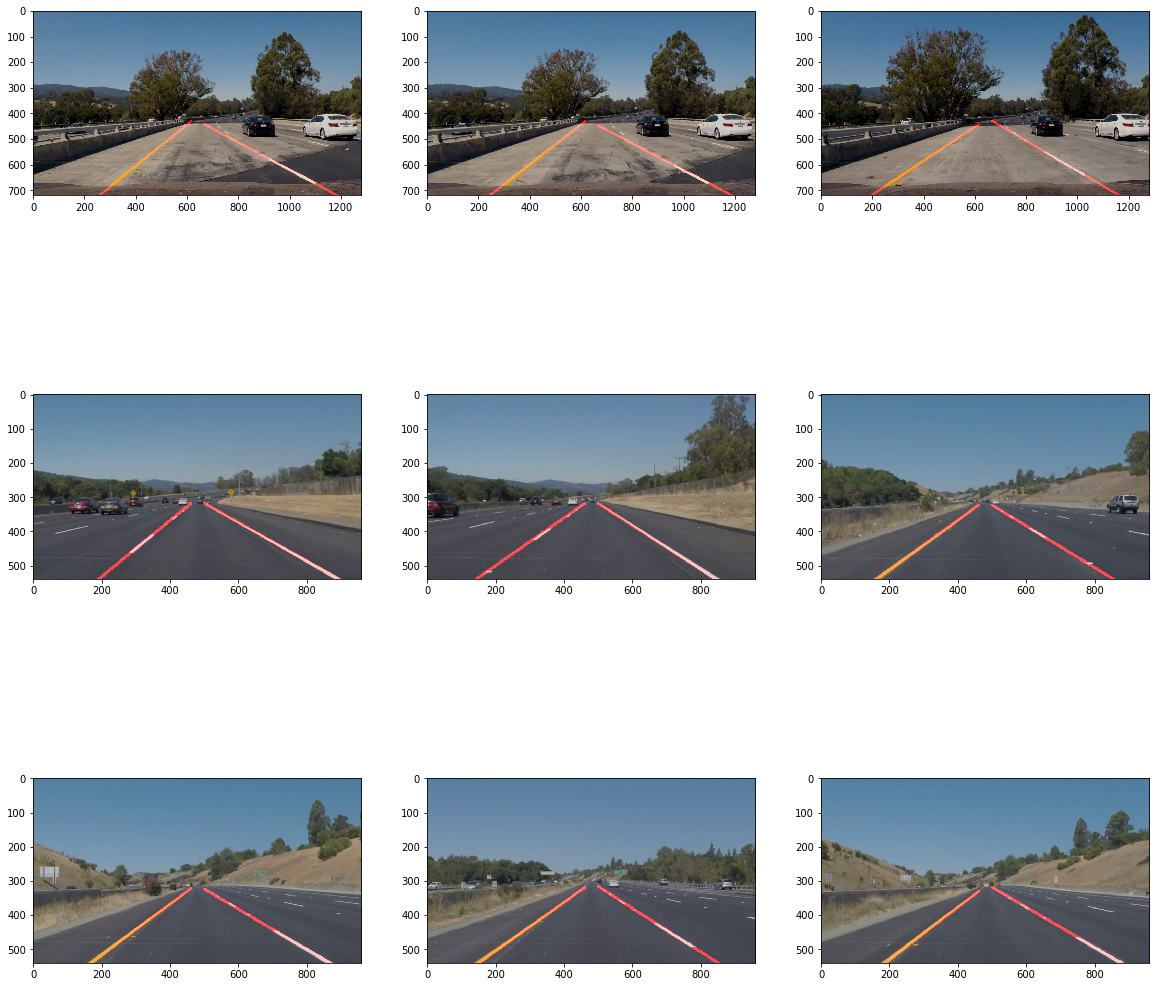

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """        
    X0 = 0.0*img.shape[1]
    X1 = 0.48*img.shape[1]
    X2 = 0.52*img.shape[1]
    X3 = 1.0*img.shape[1]
    def inter(x, slope, intercept):
        return (int(x), int(x*slope+intercept))
    
    left  = []
    right = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (y2 > y1):
                (x1,y1,x2,y2) = (x2,y2,x1,y1)
            
            # avoid division by zero in calculation of slope
            if (abs(x2-x1) < 0.01):
                continue
                
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            
            #print(slope, intercept)
            
            # ignore near vertical or near horizontal lines
            # but more biased towards verticality
            if (abs(slope) < 0.5) or (abs(slope) > 2):
                continue
    
            # Extend the line to the bottom of the image
            if slope < 0:
                (x1,y1) = inter(X0, slope, intercept)
                (x2,y2) = inter(X1, slope, intercept)
                left += [(x1,y1,x2,y2)]
            else:
                (x1,y1) = inter(X2, slope, intercept)
                (x2,y2) = inter(X3, slope, intercept)
                right += [(x1,y1,x2,y2)]

    if left:
        left = np.array(left)
        left = np.array(sum(left)/len(left), np.int32)
        cv2.line(img, (left[0],left[1]), (left[2], left[3]), color, thickness)

    if right:
        right = np.array(right)
        right = np.array(sum(right)/len(right), np.int32)
        cv2.line(img, (right[0],right[1]), (right[2], right[3]), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """    
    return cv2.addWeighted(initial_img, α, img, β, λ)



def build_vertices(image):
     #540, 960
    (y, x, _) = image.shape
    return np.array([
                  # outer trapezoid
                  [int(0.05*x), int(1.00*y)],
                  [int(0.48*x), int(0.55*y)],
                  [int(0.52*x), int(0.55*y)],
                  [int(0.95*x), int(1.00*y)],
        
                  # inner trapezoid
                  [int(0.70*x), int(1.00*y)],
                  [int(0.52*x), int(0.68*y)],
                  [int(0.48*x), int(0.68*y)],
                  [int(0.30*x), int(1.00*y)]
                 ])

def do_image(image):
    vertices = build_vertices(image)
    
    # Tuning parameters
    # yellow_sensitivity = 5
    # white_sensitivity = 80
    
    # [Updated] Initial review feedback suggested that a canny_low value of 50 might
    # be more suited.  I tried this and found that it slightly improved the results
    # for the white and yellow lines tests, but substantially reduced results for 
    # the challenge video.  Since I favor improved generalization of a slightly better
    # fit on the two easier videos I have chosen to keep the value at 75
    canny_low = 75
    canny_high = 150
    rho = 1
    theta = np.pi/180
    
    # [Updated] Initial feedback suggested changes to min from 70 - 30 and min_line_len
    # and max_line_gap from [25,25] to [100,160].  Experimentally I found that reducing
    # the threshold significantly impacted performance on the challenge video.  So I have
    # kept it at the value that I found works well.  Additionally increasing min_len_len to
    # 100 dropped the line out of more frames.  
    #
    # The values chosen in this submission are a compromize between the two, although 
    # overall performance is pretty similar.
    #
    # Original submission values:
    # threshold = 70
    # min_line_len = 25
    # max_line_gap = 25
    threshold = 70
    min_line_len = 50
    max_line_gap = 160

    # define range of yellow color and white color selection in HSV
    # lower_yellow = np.array([22-yellow_sensitivity,30,120])
    # upper_yellow = np.array([22+yellow_sensitivity,255,255])
    # lower_white = np.array([0,0,255-white_sensitivity])
    # upper_white = np.array([255,white_sensitivity,255])
    
    # Setup Pipeline
    hsv_image =  cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # [Updated] Initial feedback suggested "... for this particular domain to blur the 
    # image to the right amount for the Gaussian Filter to be optimum you must 
    # instantiated kernel_size value=3.nstantiated kernel_size value=3."
    # I have reduced from my original value of 5, but don't notice any particular 
    # improvement in the overall results
    #
    # Original submission values:
    # hsv_blurred = gaussian_blur(hsv_image, 5)
    hsv_blurred = gaussian_blur(hsv_image, 7)
    
    """
    Selection of yellow and white specifically seemed like a plausible
    approach, and given more time may be something that can improve the 
    overall results, but empirically pure edge detection on the hsv image
    seemed to do better overall
    """
    # yellow = cv2.inRange(hsv_blurred, lower_yellow, upper_yellow)
    # white = cv2.inRange(hsv_blurred, lower_white, upper_white)
    # colors = img1_bg = cv2.bitwise_or(yellow, white)
    # gray = grayscale(image)
    # blurred = gaussian_blur(gray, 5)
    
    edges = canny(hsv_blurred, canny_low, canny_high)
    mask = region_of_interest(edges, [vertices])
    lines = hough_lines(mask, rho, theta, threshold, min_line_len, max_line_gap)

    weighted = weighted_img(lines, image)
    return weighted
    
plt.figure(figsize=(20,20))

images = os.listdir("test_images")
#images = ["initial121.jpg", "initial109.jpg"]
#images = ["initial109.jpg"]

for i, filename in enumerate(images):
    image_in = mpimg.imread(os.path.join("test_images", filename))
    image_out = do_image(image_in)
    
    plt.subplot(331+i)
    plt.imshow(image_out)
    
plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [3]:
def writer(in_filename, out_filename):
    """ Closure to emit a series of files under a common prefix
    
    Written as a debugging aid to extract interesting frames from input videos
    """
    counter = 0
    def f(in_img, out_img):
        nonlocal counter, in_filename, out_filename
        
        # mpg.imsave wouldn't require the color conversion, but would add an extra channel
        # mpimg.imsave(in_filename+str(counter)+".jpg", in_img)
        # mpimg.imsave(out_filename+str(counter)+".jpg", out_img)
        cv2.imwrite(in_filename+str(counter)+".jpg", cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB))
        cv2.imwrite(out_filename+str(counter)+".jpg", cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
        counter += 1
    return f

# image_writer = writer("output/initial", "output/result")
image_writer = None

In [4]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = do_image(image)
    if image_writer:
        image_writer(image, result)
    return do_image(image)

Let's try the one with the solid white lane on the right first ...

In [5]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 34.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 11.1 s, sys: 2.19 s, total: 13.3 s
Wall time: 6.81 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [7]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:25<00:00, 26.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 40.7 s, sys: 7.59 s, total: 48.3 s
Wall time: 25.7 s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


[Updated]  Oops, original submission didn't include any thoughts here at all!  My bad, I didn't notice that I was
supposed to add some free form text.  

Here's the submission comments I included in the first submission:

I experimented with a couple different input variants for the edge detection:

- edge detection on color image
- edge detection on grayscale image
- extracting yellow and white channels prior to edge detection
- edge detection in the HSV space

In the end I found edge detection in the HSV space worked better than the above. However, the yellow and white extraction looked promising and more fine tuning could have utilized that technique to better effect.

There still seems to be some difficulty with the dotted lines and occasionally a frame will drop out a line.


Based on the feed back provided from the first review I have slightly tweaked some of the input parameters, see the code marked with [Updated] comments indicating both original submission, feedback, and the new values.  Overall the modifications haven't caused a significant change in the overall code.


For Context here are some output images based on different tests I ran coming to the final solution.


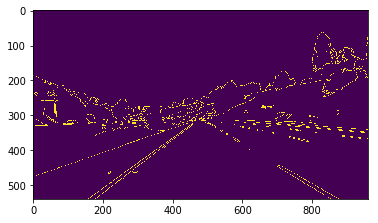

In [16]:
"""#1 - Edge Detection on a color image

Works reasonably well on the images in the "test_images" folder, but does poorly on some frames of challenge video
"""
image_in = mpimg.imread("test_images/solidYellowCurve2.jpg")
image_blurred = gaussian_blur(image_in, 3)
edges_color = canny(image_blurred, 50, 150)
plt.imshow(edges_color)
plt.show()

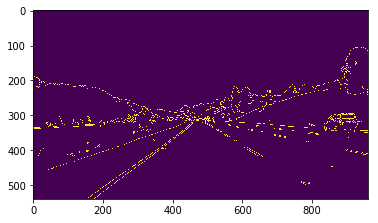

In [10]:
"""#2 - Edge detection on a grayscale image

Works reasonably well on the images in the "test_images" folder, but does poorly on some frames of challenge video
"""
image_in = mpimg.imread("test_images/solidYellowCurve.jpg")
image_gray = grayscale(image_in)
image_blurred = gaussian_blur(image_gray, 3)
edges_gray = canny(image_blurred, 50, 150)
plt.imshow(edges_gray)
plt.show()

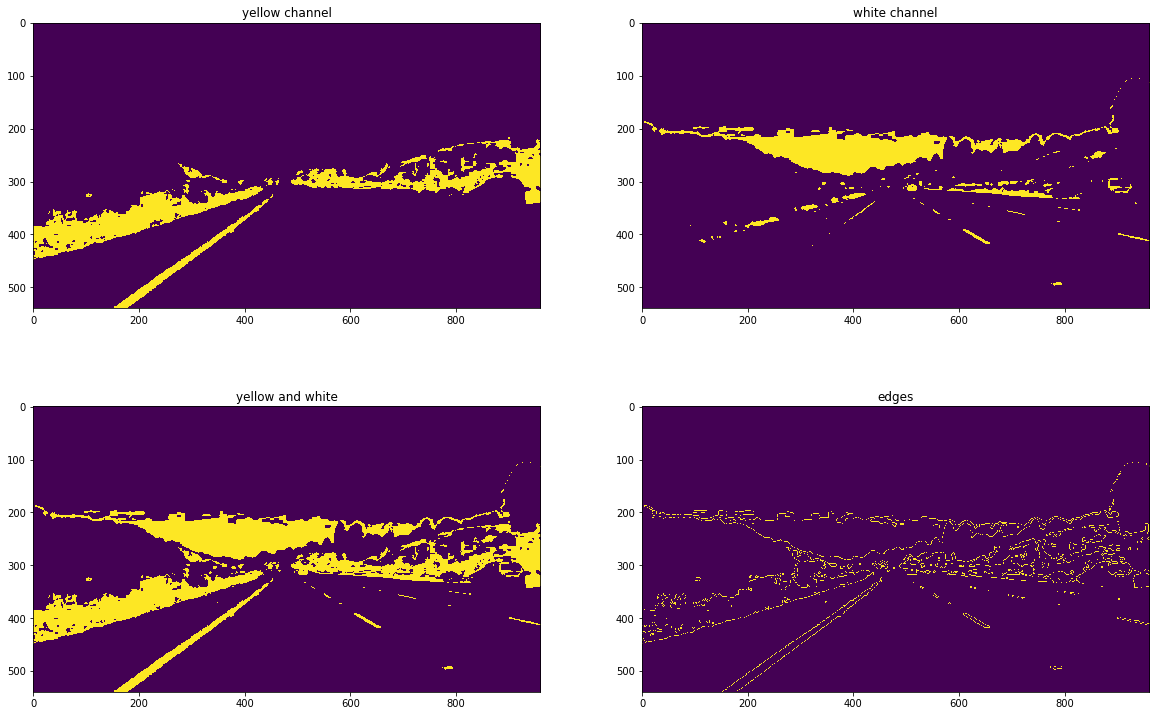

In [11]:
"""#3 - extracting yellow and white channels prior to edge detection

This approach seemed the most promising, however it had some fairly catostrophic failure
modes in the challenge video, so I fell back to #4 bellow as being a more robust method.
"""

image_in = mpimg.imread("test_images/solidYellowCurve.jpg")
hsv_image =  cv2.cvtColor(image_in, cv2.COLOR_RGB2HSV)
hsv_blurred = gaussian_blur(hsv_image, 3)

yellow_sensitivity = 5
white_sensitivity = 80
lower_yellow = np.array([22-yellow_sensitivity,30,120])
upper_yellow = np.array([22+yellow_sensitivity,255,255])
lower_white = np.array([0,0,255-white_sensitivity])
upper_white = np.array([255,white_sensitivity,255])

yellow = cv2.inRange(hsv_blurred, lower_yellow, upper_yellow)
white = cv2.inRange(hsv_blurred, lower_white, upper_white)
colors = img1_bg = cv2.bitwise_or(yellow, white)
edges_colors = canny(colors, 50, 150)

plt.figure(figsize=(20,20))
plt.subplot(321, title="yellow channel")
plt.imshow(yellow)
plt.subplot(322, title="white channel")
plt.imshow(white)
plt.subplot(323, title="yellow and white")
plt.imshow(colors)
plt.subplot(324, title="edges")
plt.imshow(edges_colors)
plt.show()


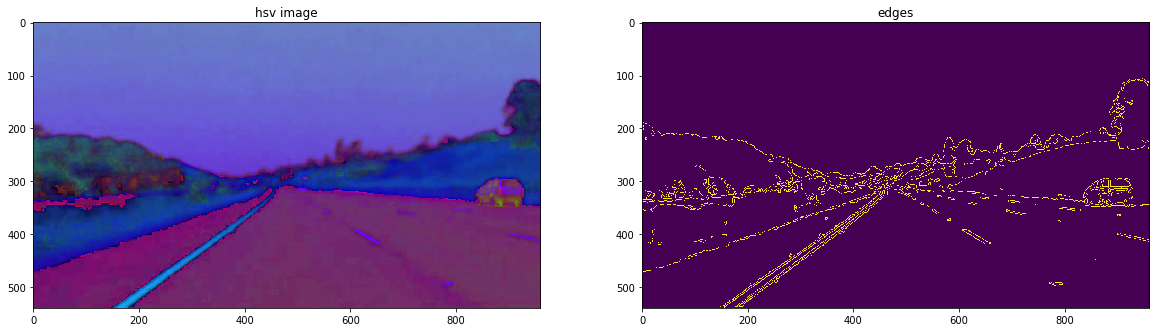

In [12]:
"""#4 - Edge detection in HSV space, note the greater separation for the yellow line

Of note in this is that the H channel cleanly separates out the yellow line while the V channel cleanly 
separates white from black, so it responds well to both yellow and white lines and outperforms all 3
other methods on the challenge video.
"""
image_in = mpimg.imread("test_images/solidYellowCurve.jpg")
hsv_image =  cv2.cvtColor(image_in, cv2.COLOR_RGB2HSV)
hsv_blurred = gaussian_blur(hsv_image, 3)
edges_hsv = canny(hsv_blurred, 50, 150)

plt.figure(figsize=(20,20))
plt.subplot(221, title="hsv image")
plt.imshow(hsv_image)
plt.subplot(222, title="edges")
plt.imshow(edges_hsv)
plt.show()

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:17<00:00, 14.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 28.1 s, sys: 4.19 s, total: 32.3 s
Wall time: 18.2 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))